In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

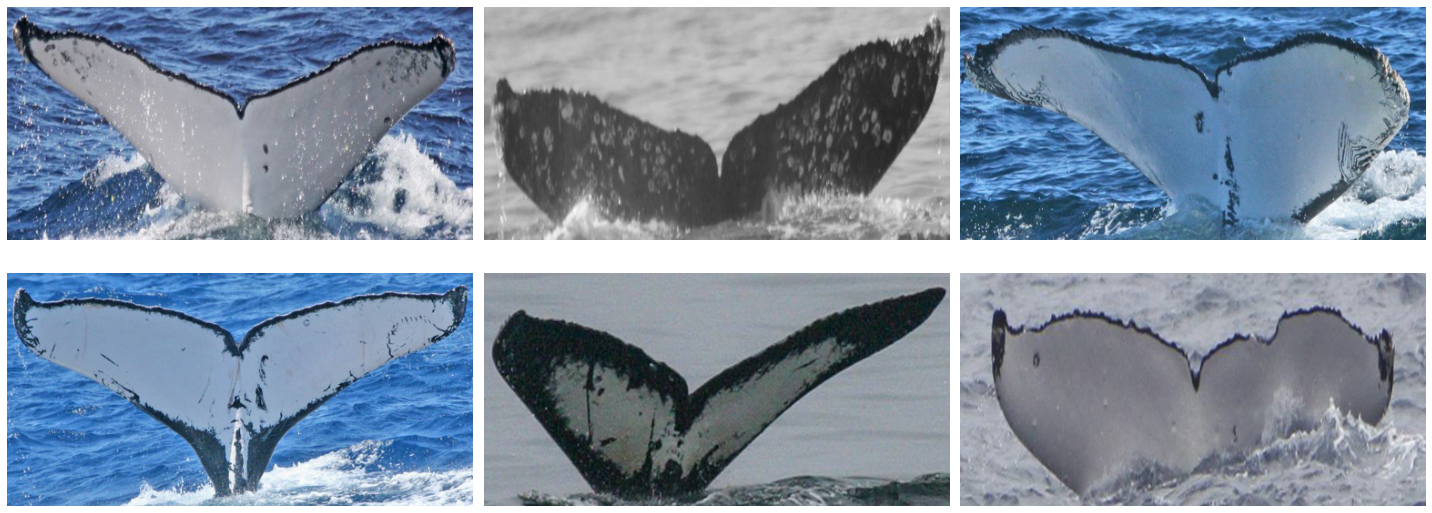

In [11]:
image_dir = '/data/research-data/humpback-whale/humpback-whale-identification/cropped_images/'
files = os.listdir(image_dir)
files = random.sample(files, 6)

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 8))
ax = ax.flatten()

for i in range(6):
    im = Image.open(os.path.join(image_dir, files[i])).convert('RGB').resize((512, 256))
    ax[i].set_axis_off()
    ax[i].imshow(im)
    
plt.tight_layout()
plt.show()

In [12]:
import faiss
import torch
import numpy as np

from humpback.utils import images_to_embeddings
from humpback.models import get_resnet
from humpback.dataset import HumpbackDataset
from humpback.transforms import get_data_loading
from humpback.metrics import map_per_set

testset = HumpbackDataset(images_dir='/data/research-data/humpback-whale/humpback-whale-identification/', 
                          csv_path='../annotations/valid_nw.csv', 
                          transforms=get_data_loading('cnn'))

device = 'cuda'
encoder = get_resnet()
encoder.load_state_dict(torch.load('/data/Progetti/humpback-identification/cosface_ckpts/ep-90.ckpt'))
encoder.eval()
print()

In [14]:
device='cuda'
embedding_dim=2048
    
print('Extracting Whales ground truth IDs.')
whales = testset.annotations.label.to_numpy()

print('Generating the embeddings.')
encoder.eval()
encoder = encoder.to(device)

embeddings = images_to_embeddings(encoder, testset, device=device, batch_size=32).astype(np.float32)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

Extracting Whales ground truth IDs.
Generating the embeddings.


In [ ]:
threshold = 0.55
faiss_index = faiss.IndexFlatIP(embedding_dim)
faiss_index.add(embeddings) # type: ignore
similarities, results = faiss_index.search(embeddings, 6) # type: ignore
similarities = similarities[:, 1:6]
predicted_whales = whales[ results[:, 1:6] ]

for res, sim in zip(predicted_whales, similarities):
    for i, s in enumerate(sim):
        if s < threshold:
            tmp = res[i]
            res[i] = -1
            if (i < 4): res[i+1] = tmp
            break

In [18]:
predicted_whales

array([[  0,  -1,  -1, 446, 456],
       [  1,  -1, 340,  91, 410],
       [  2,   2,  -1, 471,  96],
       ...,
       [ -1, 280, 262, 280,  25],
       [ -1,  -1, 189,  -1, 391],
       [ -1,  64, 139,  -1,  64]])

In [46]:
results = results[:, 1:6]

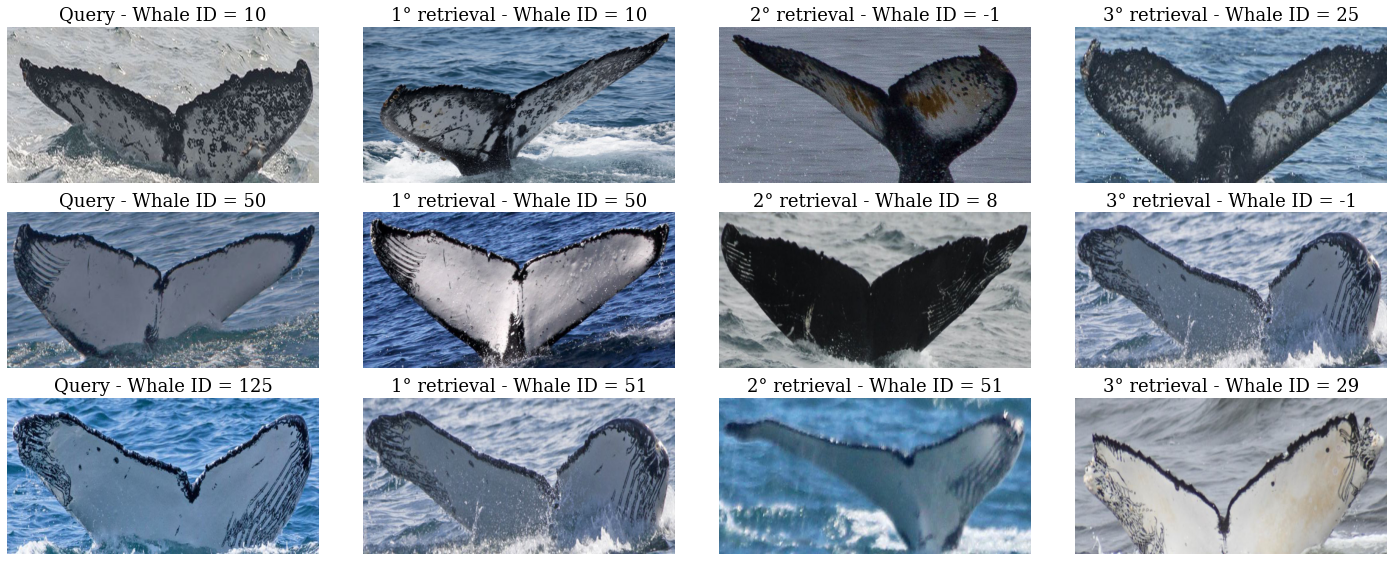

In [51]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20, 8))
ax = ax.flatten()

query_whales = [ 10, 50, 125 ]
images = testset.annotations.Image.to_list()

def imopen(imagename):
    global image_dir
    return Image.open(os.path.join(image_dir, imagename)).convert('RGB').resize((512, 256))
    

for i in range(3):
    ax_idx = i * 4
    
    query_whale = query_whales[i]
    query_im = imopen(images[query_whale])
    ax[ax_idx].set_axis_off()
    ax[ax_idx].imshow(query_im)
    ax[ax_idx].title.set_text(f'Query - Whale ID = {query_whale}')
    
    res = results[query_whale][:3]
    lab = predicted_whales[query_whale][:3]
    for j in range(1, 4):
        whale_idx = res[j-1]
        whale_lab = lab[j-1]
        retrieved_im = imopen(images[whale_idx])
        ax[ax_idx+j].set_axis_off()
        ax[ax_idx+j].imshow(retrieved_im)
        ax[ax_idx+j].title.set_text(f'{j}° retrieval - Whale ID = {whale_lab}')
        
plt.tight_layout()
plt.show()